In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import re

folder_path = 'scraped_tables/zillow_apartments'
file_list = os.listdir(folder_path)

In [36]:
apartment_data = pd.DataFrame()

# Read in the data
for file_path in file_list:
    print(file_path)
    date = file_path.split('.')[0]
    df = pd.read_csv(folder_path + '/' + file_path)
    apartment_data = apartment_data.append(df)

2022-04-24.csv
2021-01-20.csv
2021-11-24.csv
2022-01-01.csv
2022-04-25.csv
2022-03-10.csv
2020-02-05.csv
2021-03-26.csv
2020-05-18.csv
2021-04-13.csv
2020-05-24.csv
2020-10-11.csv
2020-10-05.csv
2022-01-02.csv
2021-08-12.csv
2021-08-16.csv
2022-11-16.csv
2020-09-20.csv
2021-04-17.csv
2022-01-11.csv
2021-11-09.csv
2022-04-08.csv
2022-03-01.csv
2022-04-20.csv
2020-01-08.csv
2020-06-29.csv
2020-04-10.csv
2020-04-04.csv
2021-12-02.csv
2021-10-13.csv
2020-01-09.csv
2020-04-13.csv
2020-03-27.csv
2021-12-01.csv
2021-10-04.csv
2020-08-29.csv
2021-10-17.csv
2023-03-14.csv
2020-03-08.csv
2023-03-29.csv
2020-06-11.csv
2020-01-18.csv
2020-01-24.csv
2020-01-01.csv
2020-06-08.csv
2021-10-27.csv
2022-02-06.csv
2021-09-13.csv
2021-07-16.csv
2021-07-14.csv
2020-01-02.csv
2022-02-10.csv
2021-12-21.csv
2021-05-05.csv
2021-12-20.csv
2022-02-11.csv
2020-01-03.csv
2020-01-17.csv
2020-01-13.csv
2020-01-07.csv
2021-10-09.csv
2022-02-01.csv
2020-03-16.csv
2020-03-02.csv
2021-12-25.csv
2020-01-06.csv
2020-01-12

In [37]:
len(apartment_data)

2847

### Data Cleaning

In [40]:
# Need to standardize price (e.g. $2,000/mo or $2,200+Studio)
# For those with $2,795+1 bd	$3,195+2 bds	$3,995+3 bds	--> need to split into 3 rows
apartment_data

,price,type,bathrooms,size,address,date
0,"$2,195/mo",1bd,1ba,440sqft,"1507 Harmon St, Berkeley, CA 94703",2022-04-24
1,"$2,200+Studio","$3,200+2 bds",NaN,NaN,"1720 Spruce St, Berkeley, CA",2022-04-24
2,"$2,195/mo",Studio,1ba,363sqft,"1793 Spruce St, Berkeley, CA 94709",2022-04-24
3,"$2,795+1 bd","$3,195+2 bds","$3,995+3 bds",NaN,"2211 Channing Way | 2211 Channing Way, Berkele...",2022-04-24
4,"$2,495/mo",1bd,1ba,500sqft,"1432-1434 Arch St., 1432 Arch St #G, Berkeley,...",2022-04-24
...,...,...,...,...,...,...
35,"$2,995/mo",1bd,1ba,943sqft,"1823 Spruce St #C, Berkeley, CA 94709",2021-04-21
36,"$3,600/mo",2bds,1.5ba,"1,167sqft","814 Delaware St, Berkeley, CA 94710",2021-04-21
37,"$1,500/mo",Studio,1ba,--sqft,"2214 Channing Way #3, Berkeley, CA 94704",2021-04-21
38,"$2,450/mo",1bd,1ba,650sqft,"2500 Dana St APT 3, Berkeley, CA 94704",2021-04-21


In [41]:
# Separate combined price and type entries into multiple cleaned rows (e.g., "$2,200+Studio")
# Separate already cleaned rows (e.g. $2,195/mo)

new_rows = []

def split_combined_rows(row):
    col = 0 # starting from price column, moving L to R
    while type(row[col]) == str and ('bd' in row[col] or 'Studio' in row[col]):
        if 'bd' in row[col]:
            idx = row[col].index('bd')
            price = row[col][:idx-2]
            room_type = row[col][idx-2:]
        elif 'Studio' in row[col]:
            idx = row[col].index('Studio')
            price = row[col][:idx]
            room_type = row[col][idx:]
        else:
            print('Error at', row[col])
        new_rows.append({
                        "price": price,
                        "type": room_type,
                        "bathrooms": None,
                        "size": None,
                        "address": row['address'],
                        "date": row['date']
                    })
        col += 1

for i in range(len(apartment_data)):
    row = apartment_data.iloc[i]
    split_combined_rows(row)
    if not ('bd' in row['price'] or 'Studio' in row['price']):
        new_rows.append(row.to_dict())

len(new_rows)

3814

In [42]:
apartment_data = pd.DataFrame(new_rows)

In [43]:
apartment_data['type'].unique()

array(['1bd', 'Studio', '2 bds', '1 bd', '3 bds', '2bds', '5 bds', '3bds',
       '4bds', '1bd,', '2bds,', '--bds,', 'Studio,', '5bds,', '7bds',
       '5bds', '10bds', '2', '--bds', '4 bds', '6bds', '6 bds', nan],
      dtype=object)

In [44]:
def clean_type(value):
    if pd.isna(value):
        return value  # Keep NaN values for now

    # Remove any non-alphabet characters (e.g., '$', ',', and numbers not part of the type)
    value = re.sub(r'[^a-zA-Z0-9 ]+', '', value)

    # Standardize spacing for "bd" and "bds"
    value = value.replace(" ", "").replace("bds", "bds").replace("bd", "bd")

    # Standardize common variations to a consistent format
    if value in ['1bd', '1 bd', '1', 'bds']:
        return '1bd'
    elif value in ['2bds', '2 bds', '2']:
        return '2bds'
    elif value in ['3bds', '3 bds', '3']:
        return '3bds'
    elif value in ['4bds', '4 bds', '4']:
        return '4bds'
    elif value in ['5bds', '5 bds', '5']:
        return '5bds'
    elif value in ['6bds', '6 bds', '6']:
        return '6bds'
    elif value in ['7bds', '7 bds', '7']:
        return '7bds'
    elif value in ['10bds', '10 bds']:
        return '10bds'
    elif value in ['Studio', 'studio']:
        return 'Studio'
    else:
        return value  # Return other types as is if not listed above

# Apply the cleaning function to the 'type' column
apartment_data['type'] = apartment_data['type'].apply(clean_type)
apartment_data = apartment_data[apartment_data['type'].notna()]
apartment_data['type'].unique()

array(['1bd', 'Studio', '2bds', '3bds', '5bds', '4bds', '7bds', '10bds',
       '6bds'], dtype=object)

In [45]:
# Standardize Pricing Data
apartment_data['price'] = apartment_data['price'].str.extract(r'(\$\d+(?:,\d{3})?)')[0].str.replace('$', '').str.replace(',', '').astype(int)
apartment_data

/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_38969/3722884308.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  apartment_data['price'] = apartment_data['price'].str.extract(r'(\$\d+(?:,\d{3})?)')[0].str.replace('$', '').str.replace(',', '').astype(int)


,price,type,bathrooms,size,address,date
0,2195,1bd,1ba,440sqft,"1507 Harmon St, Berkeley, CA 94703",2022-04-24
1,2200,Studio,None,None,"1720 Spruce St, Berkeley, CA",2022-04-24
2,3200,2bds,None,None,"1720 Spruce St, Berkeley, CA",2022-04-24
3,2195,Studio,1ba,363sqft,"1793 Spruce St, Berkeley, CA 94709",2022-04-24
4,2795,1bd,None,None,"2211 Channing Way | 2211 Channing Way, Berkele...",2022-04-24
...,...,...,...,...,...,...
3809,2995,1bd,1ba,943sqft,"1823 Spruce St #C, Berkeley, CA 94709",2021-04-21
3810,3600,2bds,1.5ba,"1,167sqft","814 Delaware St, Berkeley, CA 94710",2021-04-21
3811,1500,Studio,1ba,--sqft,"2214 Channing Way #3, Berkeley, CA 94704",2021-04-21
3812,2450,1bd,1ba,650sqft,"2500 Dana St APT 3, Berkeley, CA 94704",2021-04-21


In [46]:
apartment_data.to_csv('zillow_apartment_data.csv', index=False)

### Analysis by Date

In [47]:
median_prices_by_type = apartment_data.groupby(['date', 'type'])['price'].median().reset_index()
median_prices_by_type = median_prices_by_type[median_prices_by_type['type'] != '']
median_prices_by_type

,date,type,price
0,2020-01-01,1bd,2200.0
1,2020-01-01,2bds,2850.0
2,2020-01-01,3bds,3995.0
3,2020-01-01,4bds,5800.0
4,2020-01-01,Studio,1780.0
...,...,...,...
430,2024-07-08,1bd,2745.0
431,2024-07-08,2bds,3795.0
432,2024-07-08,3bds,5395.0
433,2024-07-08,4bds,6000.0


In [48]:
median_prices_by_type.to_csv('zillow_apartment_median_data.csv', index=False)

/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_38969/3489464299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_dt'] = pd.to_datetime(df['date'])


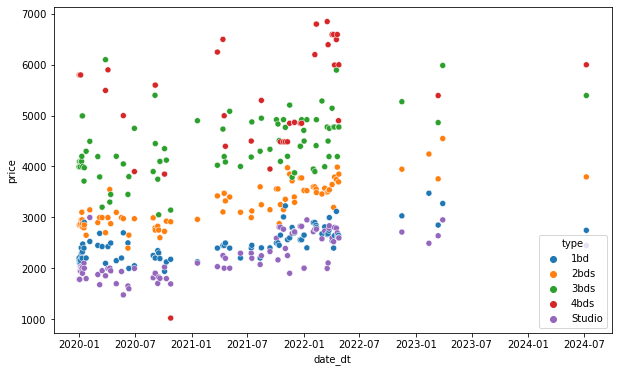

In [49]:
df = median_prices_by_type[median_prices_by_type['type'].isin(['1bd', '2bds', '3bds', '4bds', 'Studio'])]

df['date_dt'] = pd.to_datetime(df['date'])

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='date_dt', y='price', hue='type', data=df)  # Use sns.scatterplot for scatter plot instead of lineplot

# Show plot
plt.show()

/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_38969/509298667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_dt'] = pd.to_datetime(df['date'])
/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_38969/509298667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_ordinal'] = df['date_dt'].map(pd.Timestamp.toordinal)


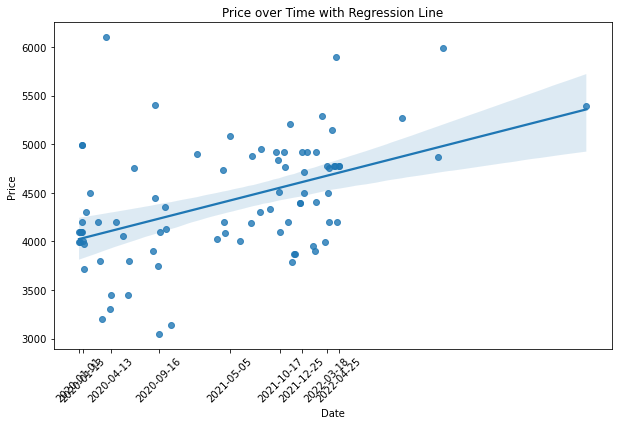

increasing ~ $295.10451208023596 per year


In [50]:
df = median_prices_by_type[median_prices_by_type['type'] == '3bds']

df['date_dt'] = pd.to_datetime(df['date'])
df['date_ordinal'] = df['date_dt'].map(pd.Timestamp.toordinal)

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='date_ordinal', y='price', data=df, scatter=True, fit_reg=True)

slope, intercept, r_value, p_value, std_err = linregress(df['date_ordinal'], df['price'])

# Set the x-axis labels back to the date format for readability
date_labels = df['date_dt'].dt.strftime('%Y-%m-%d')
plt.xticks(ticks=df['date_ordinal'][::10], labels=date_labels[::10], rotation=45)  # Adjust interval as needed
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price over Time with Regression Line")

# Show plot
plt.show()
slope, intercept, r_value, p_value, std_err
print(f'increasing ~ ${(slope * 365)} per year')

### Analysis by Year

In [52]:
apartment_data_with_years = apartment_data.copy()
apartment_data_with_years['year'] = apartment_data_with_years['date'].str.extract(r'(\d{4})').astype(int)
apartment_data_with_years

,price,type,bathrooms,size,address,date,year
0,2195,1bd,1ba,440sqft,"1507 Harmon St, Berkeley, CA 94703",2022-04-24,2022
1,2200,Studio,None,None,"1720 Spruce St, Berkeley, CA",2022-04-24,2022
2,3200,2bds,None,None,"1720 Spruce St, Berkeley, CA",2022-04-24,2022
3,2195,Studio,1ba,363sqft,"1793 Spruce St, Berkeley, CA 94709",2022-04-24,2022
4,2795,1bd,None,None,"2211 Channing Way | 2211 Channing Way, Berkele...",2022-04-24,2022
...,...,...,...,...,...,...,...
3809,2995,1bd,1ba,943sqft,"1823 Spruce St #C, Berkeley, CA 94709",2021-04-21,2021
3810,3600,2bds,1.5ba,"1,167sqft","814 Delaware St, Berkeley, CA 94710",2021-04-21,2021
3811,1500,Studio,1ba,--sqft,"2214 Channing Way #3, Berkeley, CA 94704",2021-04-21,2021
3812,2450,1bd,1ba,650sqft,"2500 Dana St APT 3, Berkeley, CA 94704",2021-04-21,2021


In [53]:
median_prices_by_year_and_type = apartment_data_with_years.groupby(['year', 'type'])['price'].median().reset_index()
median_prices_by_year_and_type = median_prices_by_year_and_type[median_prices_by_year_and_type['type'] != '']
median_prices_by_year_and_type

,year,type,price
0,2020,10bds,1950.0
1,2020,1bd,2225.0
2,2020,2bds,2895.0
3,2020,3bds,3999.0
4,2020,4bds,5600.0
5,2020,6bds,9500.0
6,2020,Studio,1895.0
7,2021,10bds,12500.0
8,2021,1bd,2495.0
9,2021,2bds,3400.0


In [54]:
median_prices_by_year_and_type.to_csv('zillow_apartment_median_data_yearly.csv', index=False)

/var/folders/b_/fy9dn1455tv05c9ybjqsbp900000gn/T/ipykernel_38969/914683054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_dt'] = pd.to_datetime(df['year'], format='%Y')


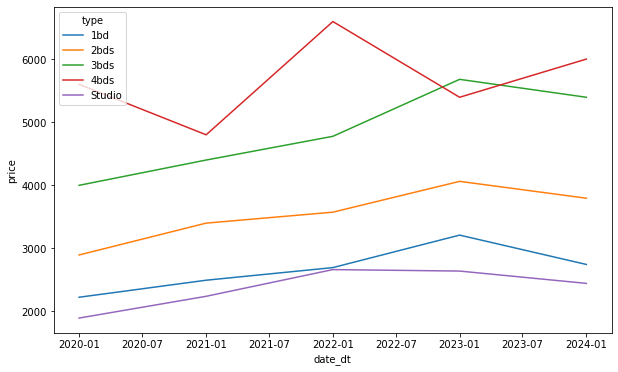

In [57]:
df = median_prices_by_year_and_type[
    median_prices_by_year_and_type['type'].isin(['1bd', '2bds', '3bds', '4bds', 'Studio'])]

df['date_dt'] = pd.to_datetime(df['year'], format='%Y')

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='date_dt', y='price', hue='type', data=df)  # Use sns.scatterplot for scatter plot instead of lineplot

# Show plot
plt.show()

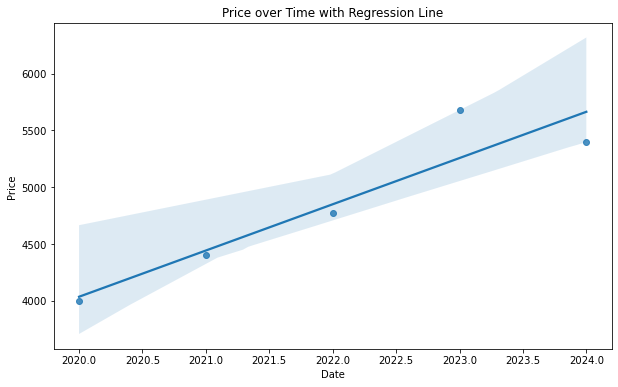

In [62]:
df = median_prices_by_year_and_type[median_prices_by_year_and_type['type'] == '3bds']

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='year', y='price', data=df, scatter=True, fit_reg=True)

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price over Time with Regression Line")

# Show plot
plt.show()